## Applied Data Science Capstone Project
# Identifying similar districts in different Peruvian provinces
### Arturo J. Miguel de Priego

This is the notebook used to retrieve and process data for the capstone project. The report can be reached in
https://github.com/ArturoMigueldePriego/Data-Science-with-IBM/blob/master/CapstoneReport.pdf. Also, the presentation is in
https://github.com/ArturoMigueldePriego/Data-Science-with-IBM/blob/master/CapstonePresentation.pdf

Data source:
Instituo Nacional de Estadística e Informática, https://www.inei.gob.pe/

In [2]:
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes
#!pip install lxml
#!pip install beautifulsoup4
#!pip install xlrd

import numpy as np
import pandas as pd
import os
from time import sleep, time

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from ipywidgets import widgets

from IPython.display import display
from IPython.display import Image

from geopy.geocoders import Nominatim

import requests
import folium

from sklearn.cluster import KMeans

In [3]:
# Get data from INEI: boroughs and populations
data = pd.read_excel("https://www.inei.gob.pe/media/MenuRecursivo/indices_tematicos/cuadro001_1.xls", 
                     index_col = 0,
                     sheet_name = '2015',
                     skiprows = 6)
data.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
PAIS,NaN,PERÚ,31151643.0,2861874.0,2922744.0,2914162.0,2887529.0,2828387.0,2661346.0,2411781.0,2258372.0,1977630.0,1725353.0,1486312.0,1205103.0,967702.0,736059.0,545659.0,394230.0,367400
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEP,10000.0,AMAZONAS,422629.0,44338.0,45917.0,43106.0,35550.0,28963.0,40879.0,34342.0,31077.0,28146.0,23433.0,18902.0,14904.0,11605.0,8533.0,6002.0,4046.0,2886
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PROV,10100.0,CHACHAPOYAS,55201.0,4589.0,4826.0,4857.0,4348.0,3935.0,5317.0,4764.0,4183.0,4271.0,3446.0,2868.0,2203.0,1889.0,1406.0,1048.0,739.0,512


In [4]:
data.dropna(inplace=True)
data = data [['Unnamed: 2', 'Unnamed: 3']]
data.reset_index(level=0, inplace=True)
data.columns = ['Type', 'Borough', 'Population']
data.head()

,Type,Borough,Population
0,DEP,AMAZONAS,422629.0
1,PROV,CHACHAPOYAS,55201.0
2,DIST,CHACHAPOYAS,28731.0
3,DIST,ASUNCIÓN,288.0
4,DIST,BALSAS,1625.0


In [5]:
data.tail()

,Type,Borough,Population
2049,DIST,PADRE ABAD,25971.0
2050,DIST,IRAZOLA,24833.0
2051,DIST,CURIMANA,8543.0
2052,PROV,PURÚS,4481.0
2053,DIST,PURÚS,4481.0


In [6]:
# Add a row to simplify the algorithm ahead to found 
# boroughs from the same PROV in the same DEP
data.at[2054, 'Type'] = 'DEP'
data.at[2054, 'Borough'] = 'Unknown'
data.at[2054, 'Population'] = 0
data.tail()

,Type,Borough,Population
2050,DIST,IRAZOLA,24833.0
2051,DIST,CURIMANA,8543.0
2052,PROV,PURÚS,4481.0
2053,DIST,PURÚS,4481.0
2054,DEP,Unknown,0.0


In [7]:
# Change the name to CALLAO for use with geolocator
i = np.where(data["Borough"] == 'PROV. CONST. DEL CALLAO')
data.at[i[0], "Borough"] = "CALLAO"
np.where(data["Borough"] == 'CALLAO')

(array([749, 750, 751], dtype=int64),)

In [8]:
data.to_csv("PeruvianPopultation2015.csv", index = False)
population = pd.read_csv("PeruvianPopultation2015.csv")
population.head()

,Type,Borough,Population
0,DEP,AMAZONAS,422629.0
1,PROV,CHACHAPOYAS,55201.0
2,DIST,CHACHAPOYAS,28731.0
3,DIST,ASUNCIÓN,288.0
4,DIST,BALSAS,1625.0


In [9]:
population.shape

(2055, 3)

In [10]:
population['Type'].value_counts()

DIST    1834
PROV     195
DEP       26
Name: Type, dtype: int64

Peru has 1834 boroughs (districts, DIST), 195 provinces (PROV) and 25 regions (departments, DEP). The result shows 26 regions because we added one more to facilitate the coding ahead. 

In [12]:
# Aggregate coordinates by regions
""" 
This routine takes almost an hour to be completed.
Delays were inserted as geolocator stopped after a number de consecutive calls,
When results are null, the search string is added to the to_do list
"""
latitudes = []
longitudes = []
to_do = []
region_name = ""
province_name = ""

geolocator = Nominatim(user_agent="explorer")

start_time = time()

for borough_type, borough_name, borough_population in zip(population['Type'],
                                                          population['Borough'], 
                                                          population['Population']):
    if borough_name == 'Unknown':
        break

    if (borough_type == 'DEP'):
        search_string = borough_name
        region_name = borough_name
        print(borough_name)
        sleep(10)  # pause between region calls
    elif (borough_type == 'PROV'):
        search_string = borough_name + ', ' + region_name
        province_name = borough_name
        print('--- ' + borough_name)
        sleep(2)  # pause between province calls
    else:
        search_string = borough_name + ', ' + province_name + ', ' + region_name

    search_string += ', Peru'

    try:
        location = geolocator.geocode(search_string, timeout = 20)
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
        #print(search_string)
    except:
        print('****** ' + search_string)
        latitudes.append(0)
        longitudes.append(0)
        to_do.append(search_string)

end_time = time()

AMAZONAS
--- CHACHAPOYAS
--- BAGUA
--- BONGARÁ
--- CONDORCANQUI
--- LUYA
--- RODRÍGUEZ DE MENDOZA
--- UTCUBAMBA
ÁNCASH
--- HUARAZ
--- AIJA
--- ANTONIO RAYMONDI
--- ASUNCIÓN
--- BOLOGNESI
--- CARHUAZ
--- CARLOS FERMÍN FITZCARRALD
--- CASMA
--- CORONGO
--- HUARI
--- HUARMEY
--- HUAYLAS
--- MARISCAL LUZURIAGA
--- OCROS
--- PALLASCA
--- POMABAMBA
--- RECUAY
--- SANTA
--- SIHUAS
--- YUNGAY
APURIMAC
--- ABANCAY
--- ANDAHUAYLAS
--- ANTABAMBA
--- AYMARAES
--- COTABAMBAS
--- CHINCHEROS
--- GRAU
AREQUIPA
--- AREQUIPA
--- CAMANÁ
--- CARAVELÍ
****** CHALA, CARAVELÍ, AREQUIPA, Peru
--- CASTILLA
--- CAYLLOMA
--- CONDESUYOS
--- ISLAY
--- LA UNIÓN
AYACUCHO
--- HUAMANGA
--- CANGALLO
--- HUANCA SANCOS
****** HUANCA SANCOS, AYACUCHO, Peru
****** SANCOS, HUANCA SANCOS, AYACUCHO, Peru
****** CARAPO, HUANCA SANCOS, AYACUCHO, Peru
****** SACSAMARCA, HUANCA SANCOS, AYACUCHO, Peru
****** SANTIAGO DE LUCANAMARCA, HUANCA SANCOS, AYACUCHO, Peru
--- HUANTA
--- LA MAR
--- LUCANAS
--- PARINACOCHAS
--- PÁUCAR DEL SAR

In [16]:
# Check for execution time
(end_time - start_time) / 60, (end_time - start_time - 25*10 - 195*2) / 60

(49.85726276636124, 39.19059609969457)

In [17]:
# to complete the table
latitudes.append(0.0)
longitudes.append(0.0)

In [18]:
# update and save the new data
population['Latitude'] = latitudes
population['Longitude'] = longitudes
population.to_csv("boroughs.csv", index = False)
boroughs = pd.read_csv("boroughs.csv")
boroughs.head()

,Type,Borough,Population,Latitude,Longitude
0,DEP,AMAZONAS,422629.0,-5.000000,-78.000000
1,PROV,CHACHAPOYAS,55201.0,-6.371827,-77.809338
2,DIST,CHACHAPOYAS,28731.0,-6.229318,-77.871463
3,DIST,ASUNCIÓN,288.0,-5.995006,-77.754407
4,DIST,BALSAS,1625.0,-6.835597,-78.018516


## Completing geolocator data

Changes was edited manually and saved to the **boroughs_fixed.csv** file.
* Internet connection was slow when looking for data that already exists.To get the data another request was executed.
* Some names are different, for example HUANCA SANCOS is the real name but HUANCASANCOS was registered in geopy database.
* A name was written without a final O in the excel file by INEI.
* In two cases NASCA must be used instead of NAZCA.
* A name was abreviatted in the excel file. A complete name was used in the request.
* An address containing the word VEINTISIETE (twenty seven) was replaced with the number 27.
* A large name was replaced by a shorter name
* Also, a misleading address was detected when getting locations for Chincha province. It was fixed with the right address.

In [18]:
# Review the to_do list
to_do

['CHALA, CARAVELÍ, AREQUIPA, Peru',
 'HUANCA SANCOS, AYACUCHO, Peru',
 'SANCOS, HUANCA SANCOS, AYACUCHO, Peru',
 'CARAPO, HUANCA SANCOS, AYACUCHO, Peru',
 'SACSAMARCA, HUANCA SANCOS, AYACUCHO, Peru',
 'SANTIAGO DE LUCANAMARCA, HUANCA SANCOS, AYACUCHO, Peru',
 'SANTA CRUZ DE TOLED, CONTUMAZÁ, CAJAMARCA, Peru',
 'CHANGUILLO, NAZCA, ICA, Peru',
 'EL INGENIO, NAZCA, ICA, Peru',
 'VEINTISIETE DE NOVIEMBRE, HUARAL, LIMA, Peru',
 'SAN FCO.DE ASIS DE YARUSYACAN, PASCO, PASCO, Peru',
 'CORONEL GREGORIO ALBARRACIN LANCHIPA, TACNA, TACNA, Peru']

In [20]:
# Internet was slow. In tha last run 'CHALA, CARAVELÍ, AREQUIPA, Peru' was not returned.
# In a former run 'OCROS, HUAMANGA, AYACUCHO, Peru' was was not returned.
location = geolocator.geocode('OCROS, HUAMANGA, AYACUCHO, Peru', timeout = 20)
location

Location(Ocros, Huamanga, Ayacucho, Peru, (-13.41260415, -73.89748710592889, 0.0))

In [21]:
# HUANCA SANCOS is the real name, but HUANCASANCOS was registered in geopy database
location = geolocator.geocode('HUANCASANCOS, AYACUCHO, Peru', timeout = 20)
location

Location(Huancasancos, Ayacucho, Peru, (-13.9583014, -74.4256366, 0.0))

In [22]:
# HUANCA SANCOS is the real name, but HUANCASANCOS was registered in geopy database
location = geolocator.geocode('SANCOS, HUANCASANCOS, AYACUCHO, Peru', timeout = 20)
location

Location(Sancos, Huancasancos, Ayacucho, Peru, (-13.9735624, -74.54874806241207, 0.0))

In [23]:
# HUANCA SANCOS is the real name, but HUANCASANCOS was registered in geopy database
location = geolocator.geocode('CARAPO, HUANCASANCOS, AYACUCHO, Peru', timeout = 20)
location

Location(Carapo, Huancasancos, Ayacucho, Peru, (-13.8371541, -74.315265, 0.0))

In [24]:
# HUANCA SANCOS is the real name, but HUANCASANCOS was registered in geopy database
location = geolocator.geocode('SACSAMARCA, HUANCASANCOS, AYACUCHO, Peru', timeout = 20)
location

Location(Sacsamarca, Huancasancos, Ayacucho, Peru, (-13.9477395, -74.3134503, 0.0))

In [25]:
# HUANCA SANCOS is the real name, but HUANCASANCOS was registered in geopy database
location = geolocator.geocode('SANTIAGO DE LUCANAMARCA, HUANCASANCOS, AYACUCHO, Peru', timeout = 20)
location

Location(Santiago de Lucanamarca, Huancasancos, Ayacucho, Peru, (-13.8435821, -74.3722148, 0.0))

In [26]:
# SANTA CRUZ DE TOLEDO is the name, but in the excel file appears without the final O
location = geolocator.geocode('SANTA CRUZ DE TOLEDO, CONTUMAZÁ, CAJAMARCA, Peru', timeout = 20)
location

Location(Santa Cruz de Toledo, Contumazá, Cajamarca, Peru, (-7.3439935, -78.8371489, 0.0))

In [27]:
# NAZCA is in the excel file, but NASCA is used in the geopy database
location = geolocator.geocode('CHANGUILLO, NASCA, ICA, Peru', timeout = 20)
location

Location(Changuillo, Nasca, Ica, Peru, (-14.6639776, -75.222762, 0.0))

In [28]:
# NAZCA is in the excel file, but NASCA is used in the geopy database
location = geolocator.geocode('EL INGENIO, NASCA, ICA, Peru', timeout = 20)
location

Location(El Ingenio, Nasca, Ica, Peru, (-14.6451139, -75.0583569, 0.0))

In [29]:
# Change VEINTISIETE for 27
location = geolocator.geocode('27 DE NOVIEMBRE, HUARAL, LIMA, Peru', timeout = 20)
location

Location(27 de noviembre, Huaral, Lima, Peru, (-11.1547744, -76.77400467151031, 0.0))

In [30]:
# The excel file has an abreviatted name, using complete name
location = geolocator.geocode('SAN FRANCISCO DE ASIS DE YARUSYACAN, PASCO, PASCO, Peru', timeout = 20)
location

Location(San Francisco de Asís de Yarusyacán, Pasco, Peru, (-10.4900668, -76.1959523, 0.0))

In [31]:
# The excel file has large, using shorter name
location = geolocator.geocode('GREGORIO ALBARRACIN, Tacna, Peru', timeout = 20)
location

Location(Gregorio Albarracin, La Esperanza, Alto de la Alianza, Tacna, 23001, Peru, (-17.9938853, -70.2541949, 0.0))

In [32]:
# Error in coordinates found after visualizing the map. Chavín and Chavin give different coordinates.
location = geolocator.geocode('chavin, chincha, ica, Peru', timeout = 20)
location

Location(Chavin, Alto Larán, Chincha, Ica, Peru, (-13.4505078, -76.1235136, 0.0))

In [33]:
location = geolocator.geocode('chavín, chincha, ica, Peru', timeout = 20)
location

Location(Chavín, Chincha, Ica, Peru, (-13.0770802, -75.9129889, 0.0))

# Getting venues

In [34]:
# Read data from the fixed file
boroughs = pd.read_csv("boroughs_fixed.csv", usecols = [1, 2, 3, 4, 5])
boroughs.head()

,Type,Borough,Population,Latitude,Longitude
0,DEP,AMAZONAS,422629.0,-5.000000,-78.000000
1,PROV,CHACHAPOYAS,55201.0,-6.371827,-77.809338
2,DIST,CHACHAPOYAS,28731.0,-6.229318,-77.871463
3,DIST,ASUNCIÓN,288.0,-5.995006,-77.754407
4,DIST,BALSAS,1625.0,-6.835597,-78.018516


In [35]:
# There are boroughs from different provinces with the same name
# When looking for boroughs the code must extract a set for the region only.
1834 - len(boroughs[boroughs['Type'] == 'DIST']['Borough'].value_counts())

145

In [36]:
# But there are not repeated names for provinces
195 - len(boroughs[boroughs['Type'] == 'PROV']['Borough'].value_counts())

0

### Data for connecting to Foursquare

In [37]:
CLIENT_ID = '------------------------------------------------'
CLIENT_SECRET = '------------------------------------------------'
VERSION = '20180605'
LIMIT = 100 # max number of venues returned by Foursquare API

### The following functions are from lab 3.

In [38]:
# function that extracts the category of the venue, from lab 3
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### The following functions were adapted or implemented using code from lab 3.

In [39]:
def map_with_venues(borough_df, zoom = 10):
    """
    'Venues' column contains the number of clusters for the 'Borough' column
    """
    df_map = folium.Map(location = [borough_df['Latitude'].mean(), borough_df['Longitude'].mean()], zoom_start = zoom)

    colors_array = cm.rainbow(np.array([0.1, 0.9]))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    for lat, lon, poi, cluster in zip(borough_df['Latitude'], 
                                      borough_df['Longitude'], 
                                      borough_df['Borough'], 
                                      borough_df['Venues']):
        n_cluster = (cluster != 0) + 0
        label = folium.Popup(str(poi) + ', venues =' + str(cluster), parse_html = True)
        folium.CircleMarker(
            [lat, lon],
            radius = 2 + cluster/2,
            popup = label,
            color = rainbow[n_cluster - 1],
            fill = True,
            fill_color = rainbow[n_cluster - 1],
            fill_opacity = 0.7).add_to(df_map)
    return df_map

In [40]:
def get_borough_venues(boroughs_df, radius = 1000):
    """
    Return the venues within a radius and the number of venues.
    Sometimes the request does not return groups. In this
    case the fucntion returns None, None
    """    
    venues = []
    n_venues = []  # number venues by boroughs
    
    search_str = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'
    for name, lat, lng in zip(boroughs_df['Borough'], 
                              boroughs_df['Latitude'], 
                              boroughs_df['Longitude']):
       
        url = search_str.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            return None, None
        
        n_venues.append(len(results))
        
        if (len(results) > 0):
            venues.append([(name, lat, lng,
                            v['venue']['name'], 
                            v['venue']['location']['lat'], 
                            v['venue']['location']['lng'],  
                            v['venue']['categories'][0]['name']) for v in results])

    venues_df = pd.DataFrame([item for venue_list in venues for item in venue_list])
    venues_df.columns = ['Borough', 'Latitude', 'Longitude', 
                         'Venue', 'Latitude', 'Longitude', 'Category']

    return venues_df, n_venues

In [41]:
def get_borough_data(num_top_venues = 5, kclusters = 5):

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Borough']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    df_venues_sorted = pd.DataFrame(columns=columns)
    df_venues_sorted['Borough'] = df_grouped['Borough']

    for ind in np.arange(df_grouped.shape[0]):
        df_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

    df_grouped_clustering = df_grouped.drop('Borough', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

    # add clustering labels
    df_venues_sorted.insert(0, 'Labels', kmeans.labels_)

    df_merged = province_df[province_df['Venues'] > 0]

    # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
    df_merged = df_merged.join(df_venues_sorted.set_index('Borough'), on='Borough')

    # create map
    map_clusters = folium.Map(location=[province_df['Latitude'].mean(), province_df['Longitude'].mean()], zoom_start=11)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Borough'], df_merged['Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return df_merged, map_clusters

### The following functions use code from lab 3, code adapted from various sources, and custom code.

In [49]:
def fill_provinces(region):
    global region_df
    
    if region == None or region == 'Select region':
        return

    index = np.where((boroughs["Borough"] == region) & (boroughs["Type"] == 'DEP'))[0]
    region_df = boroughs.iloc[index[0]: len(boroughs) + 1]
    i = np.where(region_df["Type"] == 'DEP')[0]
    region_df = region_df.iloc[1: i[1]]

    province.options = ['Select province'] + region_df[region_df['Type'] == 'PROV']['Borough'].tolist()

    
def fill_boroughs(province):
    """
    Data is saved to "borough_name.csv" without prompting.
    """
    global venues_df
    global borough_map
    global province_df
    global df_grouped
    global province_name

    if province == None or province == 'Select province':
        return
    
    province_name = province
    
    if os.path.isfile(province + '.csv'):
        province_df = pd.read_csv(province + '.csv')
        venues_df = pd.read_csv(province + '_venues.csv')
        df_grouped = pd.read_csv(province + '_grouped.csv')
    else:
        index = np.where((region_df["Borough"] == province) & (region_df["Type"] == 'PROV'))[0]
        province_df = region_df.iloc[index[0]: len(region_df) + 1]

        i = np.where(province_df["Type"] == 'PROV')[0]
        if len(i) > 1:
            province_df = province_df.iloc[1: i[1]] # np.min does not work
        else:
            province_df = province_df.iloc[1: len(province_df)]

        province_df = province_df[['Borough', 'Population', 'Latitude', 'Longitude']].set_index(np.arange(1, len(province_df) + 1))

        print("Processing venues for " + province + '...')
        venues_df, counts = get_borough_venues(province_df)
        if venues_df is None:
            print('Error with the FourSquare service')
        else:
            print('There are {} uniques categories for venues.'.format(len(venues_df['Category'].unique())))
        province_df['Venues'] = counts
        
        
        # one hot encoding
        df_onehot = pd.get_dummies(venues_df[['Category']], prefix="", prefix_sep="")

        # add neighborhood column back to dataframe
        df_onehot['Borough'] = venues_df['Borough'] 

        # move neighborhood column to the first column
        fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
        df_onehot = df_onehot[fixed_columns]
        df_grouped = df_onehot.groupby('Borough').mean().reset_index()

        province_df['Rank 1'] = np.array([""]*len(province_df))
        province_df['Rank 2'] = np.array([""]*len(province_df))
        province_df['Rank 3'] = np.array([""]*len(province_df))
        province_df['Rank 4'] = np.array([""]*len(province_df))
        province_df['Rank 5'] = np.array([""]*len(province_df))

        for hood in df_grouped['Borough']:
            temp = df_grouped[df_grouped['Borough'] == hood].T.reset_index()
            temp.columns = ['venue','freq']
            temp = temp.iloc[1:]
            temp['freq'] = temp['freq'].astype(float)*100
            temp = temp.round({'freq': 2})
            temp = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(5)

            i = np.where(province_df['Borough'] == hood)[0][0]
            for k in range(5):
                province_df.iloc[i, 5 + k] = temp.loc[k, 'venue'] + ': ' + str(temp.loc[k, 'freq']) + ' %'

    print('Ready. Execute the next cells to review data.')
    
    if not os.path.isfile(province + '.csv'):
        province_df.to_csv(province + '.csv', index=False)
        venues_df.to_csv(province + '_venues.csv', index=False)
        df_grouped.to_csv(province + '_grouped.csv', index=False)

    
    borough_map = folium.Map(location = [province_df['Latitude'].mean(), province_df['Longitude'].mean()], zoom_start = 10)

    color = colors.rgb2hex(cm.rainbow(0.2))
                                                     
    # markers for the map
    for lat, lon, poi in zip(province_df['Latitude'], province_df['Longitude'], province_df['Borough']):
        label = folium.Popup(str(poi), parse_html = True)
        folium.CircleMarker(
            [lat, lon],
            radius = 5,
            popup = label,
            color = color,
            fill = True,
            fill_color = color,
            fill_opacity = 0.8).add_to(borough_map)

## Interactive selection of boroughs

In [50]:
# region list
region_names = ['Select region'] + boroughs[boroughs['Type'] == 'DEP']['Borough'].tolist()[:-1]

# dropdown lists
region = widgets.Dropdown(description='Region', options = region_names)
province = widgets.Dropdown(description='Province', options = [])

# interactive widgets
region_w = widgets.interactive(fill_provinces, region = region)
province_w = widgets.interactive(fill_boroughs, province = province)

# visual interface
display(region_w)
display(province_w)

interactive(children=(Dropdown(description='Region', options=('Select region', 'AMAZONAS', 'ÁNCASH', 'APURIMAC…

interactive(children=(Dropdown(description='Province', options=(), value=None), Output()), _dom_classes=('widg…

In [79]:
province_df

,Borough,Population,Latitude,Longitude,Venues,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5
1,PUNO,141064.0,-15.840758,-70.028391,56,Hotel: 12.5 %,Restaurant: 12.5 %,Bar: 10.71 %,Peruvian Restaurant: 8.93 %,Hostel: 7.14 %
2,ACORA,28189.0,-14.092374,-70.341894,0,,,,,
3,AMANTANI,4447.0,-15.665001,-69.710661,3,Mountain: 100.0 %,Bar: 0.0 %,Train Station: 0.0 %,Supermarket: 0.0 %,Stadium: 0.0 %
4,ATUNCOLLA,5653.0,-15.688426,-70.143213,0,,,,,
5,CAPACHICA,11336.0,-15.642018,-69.830793,0,,,,,
6,CHUCUITO,7012.0,-16.633603,-69.301808,0,,,,,
7,COATA,8034.0,-15.570614,-69.949222,0,,,,,
8,HUATA,10353.0,-15.623749,-69.994562,0,,,,,
9,MAÑAZO,5369.0,-15.800830,-70.342733,0,,,,,
10,PAUCARCOLLA,5135.0,-15.725087,-70.073700,0,,,,,


In [80]:
borough_map

### Venues data

In [81]:
venues_df

,Borough,Latitude,Longitude,Venue,Latitude,Longitude,Category
0,PUNO,-15.840758,-70.028391,La Casa del Corregidor,-15.840441,-70.028805,Café
1,PUNO,-15.840758,-70.028391,Mojsa,-15.840457,-70.027647,Peruvian Restaurant
2,PUNO,-15.840758,-70.028391,La Casona Restaurant,-15.839279,-70.028022,Restaurant
3,PUNO,-15.840758,-70.028391,Royal Inn Hotel,-15.841345,-70.028183,Hotel
4,PUNO,-15.840758,-70.028391,Isla Taquile,-15.838142,-70.026888,Island
5,PUNO,-15.840758,-70.028391,Hotel Tierra Viva Puno Plaza,-15.839654,-70.028352,Hotel
6,PUNO,-15.840758,-70.028391,Plaza de Armas,-15.840347,-70.027836,Plaza
7,PUNO,-15.840758,-70.028391,La Hacienda Restaurant,-15.839746,-70.027811,Pizza Place
8,PUNO,-15.840758,-70.028391,La Table del Inca,-15.838293,-70.028563,French Restaurant
9,PUNO,-15.840758,-70.028391,Kamizaraky pub rock,-15.839359,-70.027801,Bar


## Relative number of venues by borough 

In [82]:
map_with_venues(province_df)

In [90]:
boroughs_with_venues_df, boroughs_with_venues_map = get_borough_data(5, 2)

In [91]:
boroughs_with_venues_df

,Borough,Population,Latitude,Longitude,Venues,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5,Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,PUNO,141064.0,-15.840758,-70.028391,56,Hotel: 12.5 %,Restaurant: 12.5 %,Bar: 10.71 %,Peruvian Restaurant: 8.93 %,Hostel: 7.14 %,1,Hotel,Restaurant,Bar,Peruvian Restaurant,Pizza Place
3,AMANTANI,4447.0,-15.665001,-69.710661,3,Mountain: 100.0 %,Bar: 0.0 %,Train Station: 0.0 %,Supermarket: 0.0 %,Stadium: 0.0 %,0,Mountain,Vegetarian / Vegan Restaurant,Italian Restaurant,Bar,Bed & Breakfast


In [92]:
boroughs_with_venues_map

In [93]:
plt.ioff()
fig = plt.figure()
plt.scatter(province_df['Population'] / 1000, province_df['Venues'])
plt.title('Population vs. Venues\n' + province_name + ', correlation: ' + \
          str(np.corrcoef(province_df['Population'], province_df['Venues'])[0][1].round(3)))
plt.xlabel('Population (in thousands)')
plt.ylabel('Number of venues')
plt.grid(True)
plt.savefig('test.png')
plt.close(fig)

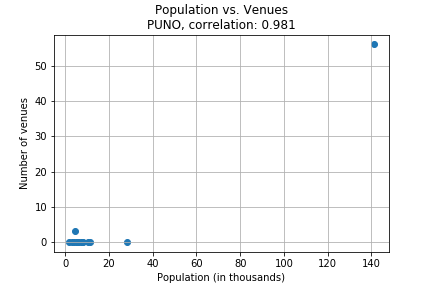

In [94]:
Image(filename='test.png')

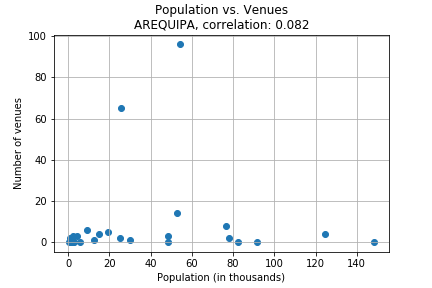

In [78]:
Image(filename='test.png')

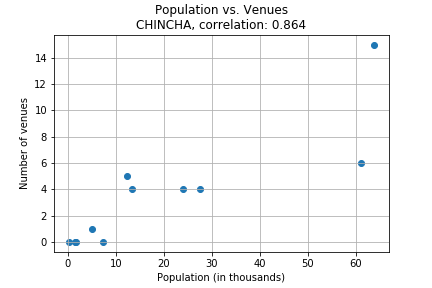

In [69]:
Image(filename='test.png')

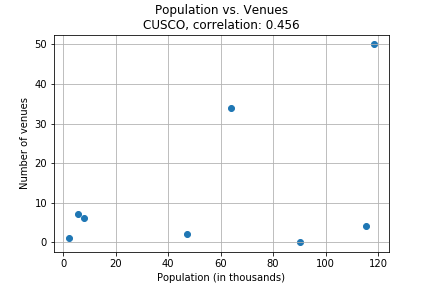

In [60]:
Image(filename='test.png')